In [ ]:
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, f1_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
import re
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import SelectKBest, f_classif
import numpy as np

In [ ]:
train_df = pd.read_csv('Training.csv')
test_df = pd.read_csv('Test.csv')

In [ ]:
train_df['summary'].fillna('', inplace=True)
test_df['summary'].fillna('', inplace=True)

In [ ]:
train_df['vote'].fillna(0, inplace=True)
test_df['vote'].fillna(0, inplace=True)

In [ ]:
train_df['label'] = train_df['overall'].apply(lambda x: 0 if x <= 3 else 1)
test_df['label'] = -1 

In [ ]:
def preprocess_text(input_text):
    # Convert to lowercase
    input_text = input_text.lower()
    # Exclude punctuation, special characters and digits
    input_text = re.sub(r'[^\w\s]', '', input_text)
    input_text = re.sub(r'\d+', '', input_text)
    # Trim extra spaces and newlines
    input_text = re.sub(r'\s+', ' ', input_text).strip()
    # Exclude stop words
    stopword_list = TfidfVectorizer(stop_words='english').get_stop_words()
    word_list = input_text.split()
    word_list = [word for word in word_list if word not in stopword_list]
    input_text = ' '.join(word_list)
    return input_text

# Define the transformer for text and variables column with SelectKBest
transformer_text_vars = ColumnTransformer([
    ('review', Pipeline([('tfidf_vect', TfidfVectorizer(stop_words='english', ngram_range=(1,1), preprocessor=preprocess_text)), 
                       ('best_k_selection', SelectKBest(f_classif, k=1000))]), 'reviewText'),
    ('summary_text', Pipeline([('tfidf_vect', TfidfVectorizer(stop_words='english', ngram_range=(1,1), preprocessor=preprocess_text)), 
                          ('best_k_selection', SelectKBest(f_classif, k=1000))]), 'summary'),
    ('verified_status', OneHotEncoder(), ['verified']),
    ('vote_count', 'passthrough', ['vote']) 
])

# Split the training dataset into train and validation sets
train_set, valid_set = train_test_split(train_df, test_size=0.2, random_state=42)

# Combine the text data with other relevant variables
train_features_transformed = transformer_text_vars.fit_transform(train_set[['reviewText', 'summary', 'verified', 'vote']], train_set['label'])
valid_features_transformed = transformer_text_vars.transform(valid_set[['reviewText', 'summary', 'verified', 'vote']])
test_features_transformed = transformer_text_vars.transform(test_df[['reviewText', 'summary', 'verified', 'vote']])
train_label_transformed = train_set['label']
valid_label_transformed = valid_set['label']

# Apply SelectKBest to the combined features
best_k_selection_final = SelectKBest(f_classif, k='all')
train_features_kbest_final = best_k_selection_final.fit_transform(train_features_transformed, train_label_transformed)
valid_features_kbest_final = best_k_selection_final.transform(valid_features_transformed)
test_features_kbest_final = best_k_selection_final.transform(test_features_transformed)

# Combine the text data with other relevant variables
train_features_final = np.hstack((train_features_kbest_final.toarray(), train_features_transformed[:, [2, 3, 4]].toarray()))
valid_features_final = np.hstack((valid_features_kbest_final.toarray(), valid_features_transformed[:, [2, 3, 4]].toarray()))
test_features_final = np.hstack((test_features_kbest_final.toarray(), test_features_transformed[:, [2, 3, 4]].toarray()))


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Mean F1 Score: 0.7382751962254004 +/- 0.0062377221683103095 for {'C': 0.1}
Mean F1 Score: 0.804098684864395 +/- 0.007082119004116507 for {'C': 0.99}
Mean F1 Score: 0.8041305303300149 +/- 0.007043538116120535 for {'C': 1}
Mean F1 Score: 0.8209597435983635 +/- 0.006250125068273395 for {'C': 10}
Mean F1 Score: 0.8220273730278228 +/- 0.005732490996879296 for {'C': 50}
Mean F1 Score: 0.8214606979698269 +/- 0.0067474244386201325 for {'C': 100}
Logistic Regression Classifier with rating cutoff of 3
Best Parameters: {'C': 50}
Best F1 Score: 0.8220273730278228
Classification Report:               precision    recall  f1-score   support

           0       0.83      0.86      0.84      3576
           1       0.76      0.72      0.74      2262

    accuracy                           0.80      5838
   macro avg       0.79      0.79      0.79      5838
weighted avg       0.80      0.80      0.80      5838

Confusion Matrix:
 [[3060  516]
 [ 635 1627]]
Accuracy: 0.802843439534087
AUC Score: 0.87969

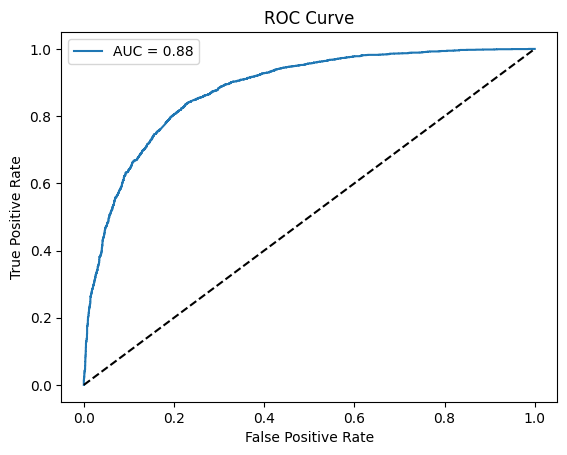

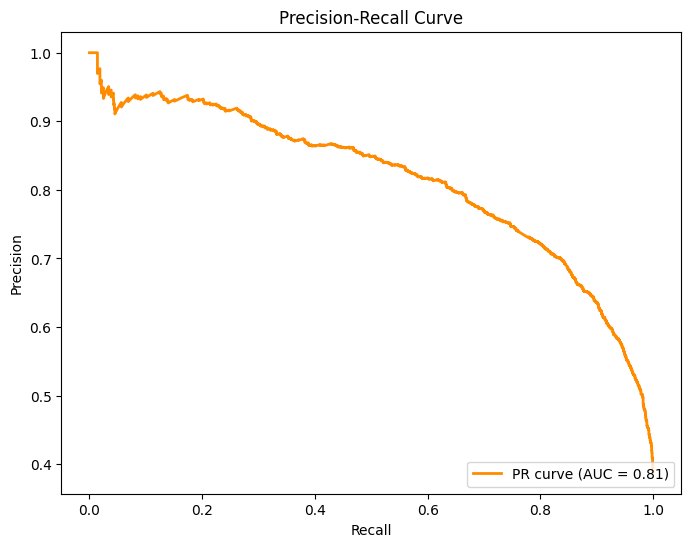

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve, precision_recall_curve, auc, f1_score
import matplotlib.pyplot as plt

# Define logistic regression classifier and its hyperparameters
logreg_clf = LogisticRegression(random_state=42, max_iter=1000)
logreg_params = {'C': [ 0.1, 0.99, 1, 10, 50, 100]}

# Train and evaluate logistic regression classifier using 5-fold cross-validation
logreg_cv = GridSearchCV(logreg_clf, logreg_params, cv=5, scoring='f1_macro')
logreg_cv.fit(train_features_final, train_label_transformed)

# Print mean and standard deviation of validation scores for each hyperparameter combination
cv_res = logreg_cv.cv_results_
for mean_val_score, std_val_score, param in zip(cv_res['mean_test_score'], cv_res['std_test_score'], cv_res['params']):
    print(f"Mean F1 Score: {mean_val_score} +/- {std_val_score} for {param}")

# Print results
print('Logistic Regression Classifier with rating cutoff of 3')
print(f"Best Parameters: {logreg_cv.best_params_}")
print(f"Best F1 Score: {logreg_cv.best_score_}")

# Compute validation metrics for best model
opt_logreg = logreg_cv.best_estimator_
valid_predictions = opt_logreg.predict(valid_features_final)
print(f"Classification Report: {classification_report(valid_label_transformed, valid_predictions)}")
print(f"Confusion Matrix:\n {confusion_matrix(valid_label_transformed, valid_predictions)}")
print(f"Accuracy: {accuracy_score(valid_label_transformed, valid_predictions)}")
print(f"AUC Score: {roc_auc_score(valid_label_transformed, opt_logreg.predict_proba(valid_features_final)[:,1])}")
print(f"Macro F1 Score: {f1_score(valid_label_transformed, valid_predictions, average='macro')}\n")

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(valid_label_transformed, opt_logreg.predict_proba(valid_features_final)[:,1])
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(valid_label_transformed, opt_logreg.predict_proba(valid_features_final)[:,1]):.2f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='black')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# Plot precision-recall curve
precision, recall, _ = precision_recall_curve(valid_label_transformed, opt_logreg.predict_proba(valid_features_final)[:,1])
pr_auc = auc(recall, precision)

plt.figure(figsize=(8,6))
plt.plot(recall, precision, color='darkorange', lw=2, label='PR curve (AUC = %0.2f)' % pr_auc)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# Use best classifier to predict on test data
test_predictions = opt_logreg.predict(test_features_final)
test_df['binary_split_3'] = test_predictions

# Write submission file in required format
submission_df = pd.DataFrame({'id': test_df.index, 'binary_split_3': test_df['binary_split_3']})
submission_df.to_csv('Logistic_Regression_3_submission.csv', index=False)


Mean F1 Score: 0.5445097145287479 +/- 0.0069515508767673 for {'C': 0.01, 'penalty': 'l1', 'solver': 'liblinear'}
Mean F1 Score: 0.5838536459892812 +/- 0.006796298731145324 for {'C': 0.01, 'penalty': 'l2', 'solver': 'liblinear'}
Mean F1 Score: 0.6905276634465968 +/- 0.007726862393369851 for {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}
Mean F1 Score: 0.7385248869246902 +/- 0.006276386729564145 for {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
Mean F1 Score: 0.793222567480574 +/- 0.0061825549820174915 for {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}
Mean F1 Score: 0.8041301756287524 +/- 0.007126627939406345 for {'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}
Mean F1 Score: 0.8179243710390512 +/- 0.005536076827533064 for {'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}
Mean F1 Score: 0.8209104314172831 +/- 0.00624112718804868 for {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
Mean F1 Score: 0.8185856478664094 +/- 0.00725297804833994 for {'C': 100, 'penalty': 'l1', 'solv

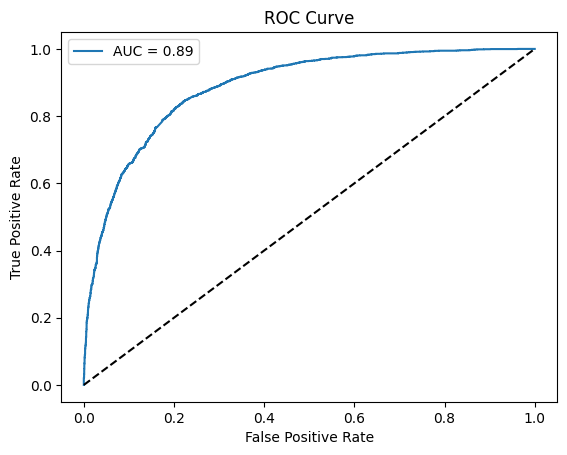

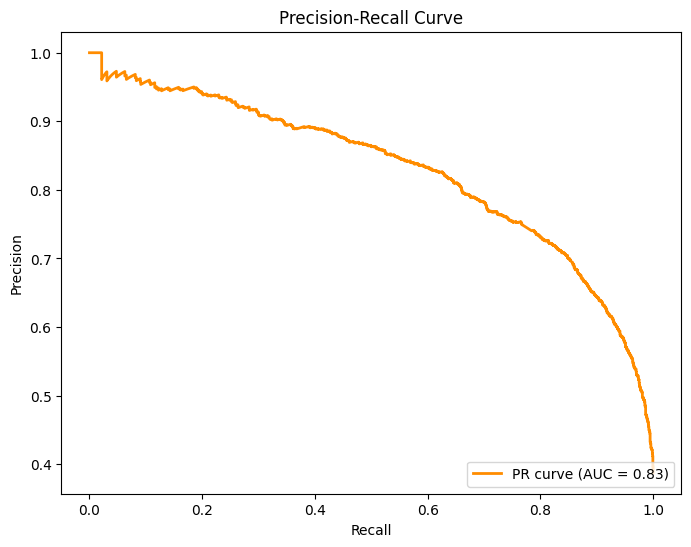

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve, precision_recall_curve, auc, f1_score
import matplotlib.pyplot as plt

# Define logistic regression classifier and its hyperparameters
logreg_clf = LogisticRegression(random_state=42, max_iter=1000)

# Adjusted hyperparameters
logreg_params = {'penalty': ['l1', 'l2'],
                 'C': [0.01, 0.1, 1, 10, 100, 1000],
                 'solver': ['liblinear']}

# Train and evaluate logistic regression classifier using 5-fold cross-validation
logreg_cv = GridSearchCV(logreg_clf, logreg_params, cv=5, scoring='f1_macro')
logreg_cv.fit(train_features_final, train_label_transformed)

# Print mean and standard deviation of validation scores for each hyperparameter combination
cv_res = logreg_cv.cv_results_
for mean_val_score, std_val_score, param in zip(cv_res['mean_test_score'], cv_res['std_test_score'], cv_res['params']):
    print(f"Mean F1 Score: {mean_val_score} +/- {std_val_score} for {param}")

# Print results
print('Logistic Regression Classifier with rating cutoff of 3')
print(f"Best Parameters: {logreg_cv.best_params_}")
print(f"Best F1 Score: {logreg_cv.best_score_}")

# Compute validation metrics for best model
opt_logreg = logreg_cv.best_estimator_
valid_predictions = opt_logreg.predict(valid_features_final)
print(f"Classification Report: {classification_report(valid_label_transformed, valid_predictions)}")
print(f"Confusion Matrix:\n {confusion_matrix(valid_label_transformed, valid_predictions)}")
print(f"Accuracy: {accuracy_score(valid_label_transformed, valid_predictions)}")
print(f"AUC Score: {roc_auc_score(valid_label_transformed, opt_logreg.predict_proba(valid_features_final)[:,1])}")
print(f"Macro F1 Score: {f1_score(valid_label_transformed, valid_predictions, average='macro')}\n")

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(valid_label_transformed, opt_logreg.predict_proba(valid_features_final)[:,1])
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(valid_label_transformed, opt_logreg.predict_proba(valid_features_final)[:,1]):.2f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='black')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# Plot precision-recall curve
precision, recall, _ = precision_recall_curve(valid_label_transformed, opt_logreg.predict_proba(valid_features_final)[:,1])
pr_auc = auc(recall, precision)

plt.figure(figsize=(8,6))
plt.plot(recall, precision, color='darkorange', lw=2, label='PR curve (AUC = %0.2f)' % pr_auc)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower right")
plt.show()

# Use best classifier to predict on test data
test_predictions = opt_logreg.predict(test_features_final)
test_df['binary_split_3'] = test_predictions

# Write submission file in required format
submission_df = pd.DataFrame({'id': test_df.index, 'binary_split_3': test_df['binary_split_3']})
submission_df.to_csv('Logistic_Regression_3_2_submission.csv', index=False)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve, precision_recall_curve, auc, f1_score
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import numpy as np

# If the data is imbalanced, using SMOTE to oversample the minority class
smote = SMOTE(random_state=42)
train_features_final, train_label_transformed = smote.fit_resample(train_features_final, train_label_transformed)

# Standardize the features, as logistic regression can be sensitive to the scale of the data
scaler = StandardScaler()
train_features_final = scaler.fit_transform(train_features_final)
valid_features_final = scaler.transform(valid_features_final)

# Define logistic regression classifier and its hyperparameters
logreg_clf = LogisticRegression(random_state=42, max_iter=1000)

# Adjusted hyperparameters
logreg_params = {'penalty': ['l1', 'l2'],
                 'C': [0.01, 0.1, 1, 10, 100, 1000],
                 'solver': ['liblinear']}

# Train and evaluate logistic regression classifier using 5-fold cross-validation
logreg_cv = GridSearchCV(logreg_clf, logreg_params, cv=5, scoring='f1_macro')
logreg_cv.fit(train_features_final, train_label_transformed)

# Print mean and standard deviation of validation scores for each hyperparameter combination
cv_res = logreg_cv.cv_results_
for mean_val_score, std_val_score, param in zip(cv_res['mean_test_score'], cv_res['std_test_score'], cv_res['params']):
    print(f"Mean F1 Score: {mean_val_score} +/- {std_val_score} for {param}")

# Print results
print('Logistic Regression Classifier with rating cutoff of 3')
print(f"Best Parameters: {logreg_cv.best_params_}")
print(f"Best F1 Score: {logreg_cv.best_score_}")

# Compute validation metrics for best model
opt_logreg = logreg_cv.best_estimator_

# Adjust the classification threshold to improve performance
thresholds = np.arange(0, 1.01, 0.01)
best_f1, best_threshold = 0, 0
for threshold in thresholds:
    valid_predictions = (opt_logreg.predict_proba(valid_features_final)[:,1] >= threshold).astype(int)
    f1 = f1_score(valid_label_transformed, valid_predictions, average='macro')
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = threshold

print(f"Best threshold: {best_threshold}")
print(f"Best F1 Score with adjusted threshold: {best_f1}")

# Compute validation metrics with best threshold
valid_predictions = (opt_logreg.predict_proba(valid_features_final)[:,1] >= best_threshold).astype(int)
print(f"Classification Report: {classification_report(valid_label_transformed, valid_predictions)}")
print(f"Confusion Matrix:\n {confusion_matrix(valid_label_transformed, valid_predictions)}")
print(f"Accuracy: {accuracy_score(valid_label_transformed, valid_predictions)}")
print(f"AUC Score: {roc_auc_score(valid_label_transformed, opt_logreg.predict_proba(valid_features_final)[:,1])}")
print(f"Macro F1 Score: {f1_score(valid_label_transformed, valid_predictions, average='macro')}\n")

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(valid_label_transformed, opt_logreg.predict_proba(valid_features_final)[:,1])
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(valid_label_transformed, opt_logreg.predict_proba(valid_features_final)[:,1]):.2f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='black')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# Plot precision-recall curve
precision, recall, _ = precision_recall_curve(valid_label_transformed, opt_logreg.predict_proba(valid_features_final)[:,1])
pr_auc = auc(recall, precision)

plt.figure(figsize=(8,6))
plt.plot(recall, precision, color='darkorange', lw=2, label='PR curve (AUC = %0.2f)' % pr_auc)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower right")
plt.show()

# Use best classifier to predict on test data
test_predictions = opt_logreg.predict(test_features_final)
test_df['binary_split_3'] = test_predictions

# Write submission file in required format
submission_df = pd.DataFrame({'id': test_df.index, 'binary_split_3': test_df['binary_split_3']})
submission_df.to_csv('Logistic_Regression_3_2_submission.csv', index=False)

Mean F1 Score: 0.8020485165155865 +/- 0.002854795455964016 for {'alpha': 0.001}
Mean F1 Score: 0.7989341362753593 +/- 0.0030002508003538837 for {'alpha': 0.1}
Mean F1 Score: 0.7926627783891771 +/- 0.0032506908403834222 for {'alpha': 0.5}
Mean F1 Score: 0.7878202206039943 +/- 0.0038421986733961667 for {'alpha': 1.0}
Mean F1 Score: 0.7819793852347385 +/- 0.0034543007918268176 for {'alpha': 2.0}
Multinomial Naive Bayes Classifier with rating cutoff of 3
Best Parameters: {'alpha': 0.001}
Best F1 Score: 0.8020485165155865
Classification Report:               precision    recall  f1-score   support

           0       0.83      0.82      0.82      3576
           1       0.71      0.73      0.72      2262

    accuracy                           0.78      5838
   macro avg       0.77      0.77      0.77      5838
weighted avg       0.78      0.78      0.78      5838

Confusion Matrix:
 [[2919  657]
 [ 614 1648]]
Accuracy: 0.7822884549503255
AUC Score: 0.8468288442252803



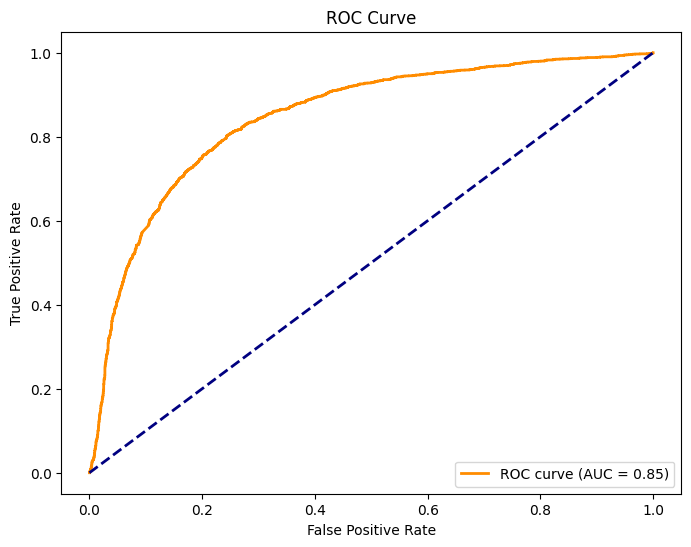

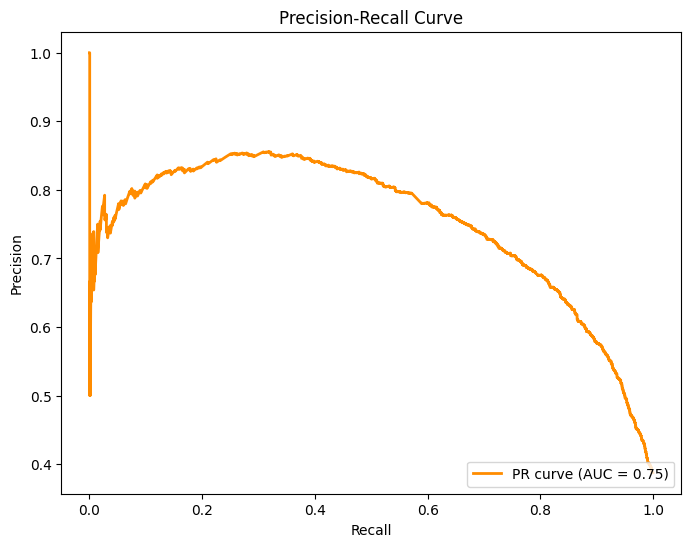

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve, precision_recall_curve, auc
import matplotlib.pyplot as plt

# Define the Multinomial Naive Bayes classifier and its hyperparameters
nb = MultinomialNB()
nb_params = {'alpha': [0.001, 0.1, 0.5, 1.0, 2.0]}

# Train and evaluate the Multinomial Naive Bayes classifier using 5-fold cross-validation
nb_grid = GridSearchCV(nb, nb_params, cv=5, scoring='f1_macro')
nb_grid.fit(train_features_final, train_label_transformed)

# Print the mean and standard deviation of the validation scores for each hyperparameter combination
cv_results = nb_grid.cv_results_
for mean_score, std_score, params in zip(cv_results['mean_test_score'], cv_results['std_test_score'], cv_results['params']):
    print("Mean F1 Score:", mean_score, "+/-", std_score, "for", params)

# Print the results
print('Multinomial Naive Bayes Classifier with rating cutoff of 3')
print('Best Parameters:', nb_grid.best_params_)
print('Best F1 Score:', nb_grid.best_score_)

# Compute the validation metrics for the best model
best_nb = nb_grid.best_estimator_
valid_pred = best_nb.predict(valid_features_final)
print('Classification Report:', classification_report(valid_label_transformed, valid_pred))
print('Confusion Matrix:\n', confusion_matrix(valid_label_transformed, valid_pred))
print('Accuracy:', accuracy_score(valid_label_transformed, valid_pred))
print('AUC Score:', roc_auc_score(valid_label_transformed, best_nb.predict_proba(valid_features_final)[:,1]))
print('')

# Plot ROC curve
fpr, tpr, _ = roc_curve(valid_label_transformed, best_nb.predict_proba(valid_features_final)[:,1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

# Plot precision-recall curve
precision, recall, _ = precision_recall_curve(valid_label_transformed, best_nb.predict_proba(valid_features_final)[:,1])
pr_auc = auc(recall, precision)

plt.figure(figsize=(8,6))
plt.plot(recall, precision, color='darkorange', lw=2, label='PR curve (AUC = %0.2f)' % pr_auc)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower right")
plt.show()


In [ ]:
# Use the best classifier to make predictions on the test data
test_pred = best_nb.predict(test_features_final)
test_df['binary_split_3'] = test_pred

# Write the submission file in the required format
submission_df = pd.DataFrame({'id': test_df.index, 'binary_split_3': test_df['binary_split_3']})
submission_df.to_csv('Multinomial_NB_3_withoutSK_submission.csv', index=False)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Mean F1 Score: 0.6753935197798142 +/- 0.008101279695296448 for {'C': 0.01}
Mean F1 Score: 0.7528143735987193 +/- 0.006320034868180484 for {'C': 0.1}
Mean F1 Score: 0.813227200083832 +/- 0.004060731216137276 for {'C': 0.99}
Mean F1 Score: 0.8137533523049285 +/- 0.003930141182829887 for {'C': 1}
Mean F1 Score: 0.8381765997620227 +/- 0.004039637717798735 for {'C': 10}
Mean F1 Score: 0.840781256683572 +/- 0.0030111218136224934 for {'C': 50}
Mean F1 Score: 0.839384926705959 +/- 0.0031868440036194076 for {'C': 100}
Logistic Regression Classifier with rating cutoff of 3
Best Parameters: {'C': 50}
Best F1 Score: 0.840781256683572
Classification Report:               precision    recall  f1-score   support

           0       0.86      0.82      0.84      3576
           1       0.74      0.78      0.76      2262

    accuracy                           0.81      5838
   macro avg       0.80      0.80      0.80      5838
weighted avg       0.81      0.81      0.81      5838

Confusion Matrix:
 [

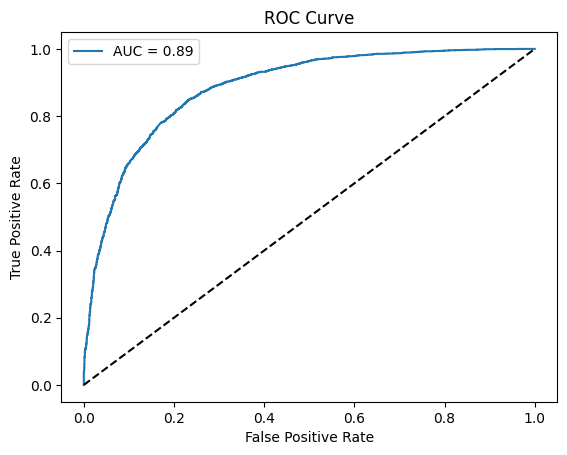

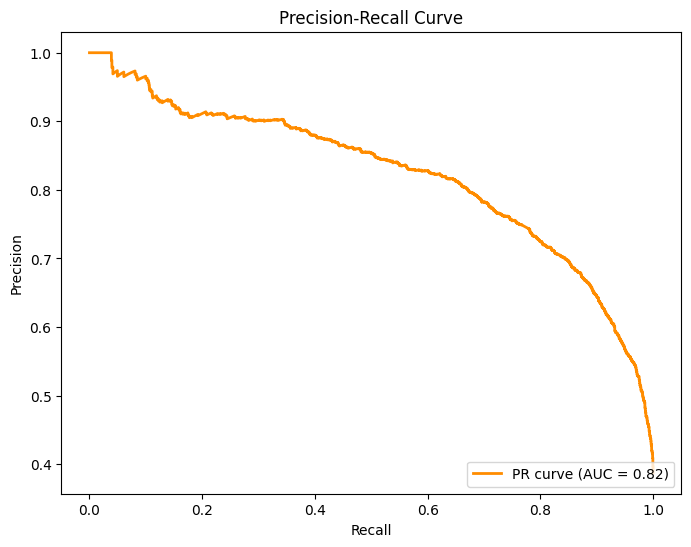

In [ ]:
#NEW MODEL FOR LR3

import pandas as pd
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve, precision_recall_curve, auc, f1_score
import matplotlib.pyplot as plt

# Load data
train_df = pd.read_csv('Training.csv')
test_df = pd.read_csv('Test.csv')

# Fill missing values
train_df['summary'].fillna('', inplace=True)
test_df['summary'].fillna('', inplace=True)
train_df['vote'].fillna(0, inplace=True)
test_df['vote'].fillna(0, inplace=True)

# Create label
train_df['label'] = train_df['overall'].apply(lambda x: 0 if x <= 3 else 1)
test_df['label'] = -1 

def preprocess_text(input_text):
    # Convert to lowercase
    input_text = input_text.lower()
    # Exclude punctuation, special characters and digits
    input_text = re.sub(r'[^\w\s]', '', input_text)
    input_text = re.sub(r'\d+', '', input_text)
    # Trim extra spaces and newlines
    input_text = re.sub(r'\s+', ' ', input_text).strip()
    # Exclude stop words
    stopword_list = TfidfVectorizer(stop_words='english').get_stop_words()
    word_list = input_text.split()
    word_list = [word for word in word_list if word not in stopword_list]
    input_text = ' '.join(word_list)
    return input_text

# Define the transformer for text and variables column with SelectKBest
transformer_text_vars = ColumnTransformer([
    ('review', Pipeline([('tfidf_vect', TfidfVectorizer(stop_words='english', ngram_range=(1,2), preprocessor=preprocess_text)), 
                       ('best_k_selection', SelectKBest(f_classif, k=5000))]), 'reviewText'),
    ('summary_text', Pipeline([('tfidf_vect', TfidfVectorizer(stop_words='english', ngram_range=(1,2), preprocessor=preprocess_text)), 
                          ('best_k_selection', SelectKBest(f_classif, k=5000))]), 'summary'),
    ('verified_status', OneHotEncoder(), ['verified']),
    ('vote_count', 'passthrough', ['vote']) 
])

# Split the training dataset into train and validation sets
train_set, valid_set = train_test_split(train_df, test_size=0.2, random_state=42)

# Combine the text data with other relevant variables
train_features_transformed = transformer_text_vars.fit_transform(train_set[['reviewText', 'summary', 'verified', 'vote']], train_set['label'])
valid_features_transformed = transformer_text_vars.transform(valid_set[['reviewText', 'summary', 'verified', 'vote']])
test_features_transformed = transformer_text_vars.transform(test_df[['reviewText', 'summary', 'verified', 'vote']])
train_label_transformed = train_set['label']
valid_label_transformed = valid_set['label']

# Define logistic regression classifier and its hyperparameters
logreg_clf = LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced')
logreg_params = {'C': [ 0.01, 0.1, 0.99, 1, 10, 50, 100]}

# Train and evaluate logistic regression classifier using 5-fold cross-validation
logreg_cv = GridSearchCV(logreg_clf, logreg_params, cv=5, scoring='f1_macro')
logreg_cv.fit(train_features_transformed, train_label_transformed)

# Print mean and standard deviation of validation scores for each hyperparameter combination
cv_res = logreg_cv.cv_results_
for mean_val_score, std_val_score, param in zip(cv_res['mean_test_score'], cv_res['std_test_score'], cv_res['params']):
    print(f"Mean F1 Score: {mean_val_score} +/- {std_val_score} for {param}")

# Print results
print('Logistic Regression Classifier with rating cutoff of 3')
print(f"Best Parameters: {logreg_cv.best_params_}")
print(f"Best F1 Score: {logreg_cv.best_score_}")

# Compute validation metrics for best model
opt_logreg = logreg_cv.best_estimator_
valid_predictions = opt_logreg.predict(valid_features_transformed)
print(f"Classification Report: {classification_report(valid_label_transformed, valid_predictions)}")
print(f"Confusion Matrix:\n {confusion_matrix(valid_label_transformed, valid_predictions)}")
print(f"Accuracy: {accuracy_score(valid_label_transformed, valid_predictions)}")
print(f"AUC Score: {roc_auc_score(valid_label_transformed, opt_logreg.predict_proba(valid_features_transformed)[:,1])}")
print(f"Macro F1 Score: {f1_score(valid_label_transformed, valid_predictions, average='macro')}\n")

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(valid_label_transformed, opt_logreg.predict_proba(valid_features_transformed)[:,1])
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(valid_label_transformed, opt_logreg.predict_proba(valid_features_transformed)[:,1]):.2f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='black')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# Plot precision-recall curve
precision, recall, _ = precision_recall_curve(valid_label_transformed, opt_logreg.predict_proba(valid_features_transformed)[:,1])
pr_auc = auc(recall, precision)

plt.figure(figsize=(8,6))
plt.plot(recall, precision, color='darkorange', lw=2, label='PR curve (AUC = %0.2f)' % pr_auc)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower right")
plt.show()


In [ ]:
# Use the best classifier to predict on test data
test_predictions = opt_logreg.predict(test_features_transformed)
test_df['binary_split_3'] = test_predictions

# Write submission file in the required format
submission_df = pd.DataFrame({'id': test_df.index, 'binary_split_3': test_df['binary_split_3']})
submission_df.to_csv('Logistic_Regression_LR3_4_submission.csv', index=False)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Mean F1 Score: 0.6836305963323416 +/- 0.005260231372991816 for {'C': 0.1}
Mean F1 Score: 0.781390717108733 +/- 0.008367344055526835 for {'C': 0.99}
Mean F1 Score: 0.7815621042648575 +/- 0.008122237620385227 for {'C': 1}
Mean F1 Score: 0.7921508753376717 +/- 0.006371536987223041 for {'C': 10}
Mean F1 Score: 0.789776872294088 +/- 0.007306482265828784 for {'C': 50}
Mean F1 Score: 0.7873068159319712 +/- 0.007590788692419494 for {'C': 100}
Logistic Regression Classifier with rating cutoff of 3
Best Parameters: {'C': 10}
Best F1 Score: 0.7921508753376717
Classification Report:               precision    recall  f1-score   support

           0       0.85      0.86      0.85      3576
           1       0.77      0.76      0.77      2262

    accuracy                           0.82      5838
   macro avg       0.81      0.81      0.81      5838
weighted avg       0.82      0.82      0.82      5838

Confusion Matrix:
 [[3058  518]
 [ 535 1727]]
Accuracy: 0.8196300102774923
AUC Score: 0.8960901

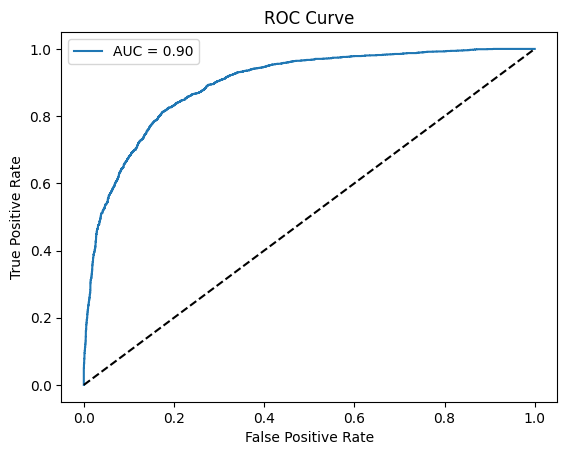

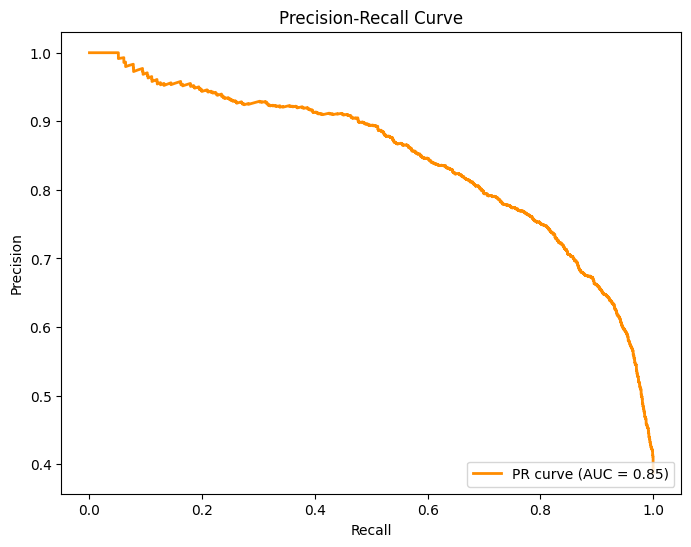

In [18]:
#New tree model
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, f1_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
import re
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import SelectKBest, f_classif
import numpy as np

# Load the data
train_df = pd.read_csv('Training.csv')
test_df = pd.read_csv('Test.csv')

# Drop columns with high number of NaN values
train_df.drop(columns=['reviewerName', 'image', 'style', 'category'], inplace=True) 
test_df.drop(columns=['reviewerName', 'image', 'style', 'category'], inplace=True)

# Replace missing values in 'summary' columns with an empty string
train_df['summary'].fillna('', inplace=True)
test_df['summary'].fillna('', inplace=True)

# Replace NaN values in 'vote' column with 0
train_df['vote'].fillna(0, inplace=True)
test_df['vote'].fillna(0, inplace=True)

# Convert the 'overall' rating to a binary label based on the cutoff value
train_df['label'] = train_df['overall'].apply(lambda x: 0 if x <= 3 else 1)
test_df['label'] = -1 # Placeholder label for the test data

def text_preprocessing(text):
    # Convert to lowercase
    text = text.lower()
    # Remove punctuation, special characters and digits
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    # Remove extra spaces and newlines
    text = re.sub(r'\s+', ' ', text).strip()
    # Remove stop words
    stopwords = TfidfVectorizer(stop_words='english').get_stop_words()
    words = text.split()
    words = [word for word in words if word not in stopwords]
    text = ' '.join(words)
    return text

# Define the text and relevant variables column transformer with SelectKBest
text_and_vars_transformer = ColumnTransformer([
    ('text', TfidfVectorizer(stop_words='english', ngram_range=(1,2), preprocessor=text_preprocessing), 'reviewText'),
    ('summary', TfidfVectorizer(stop_words='english', ngram_range=(1,2), preprocessor=text_preprocessing), 'summary'),
    ('verified', OneHotEncoder(), ['verified']), # Encode the 'verified' column
    ('vote', 'passthrough', ['vote'])
])

# Split the training data into training and validation sets
train_df, valid_df = train_test_split(train_df, test_size=0.2, random_state=42)

# Concatenate the text data with other relevant variables
train_features = text_and_vars_transformer.fit_transform(train_df[['reviewText', 'summary', 'verified', 'vote']])
valid_features = text_and_vars_transformer.transform(valid_df[['reviewText', 'summary', 'verified', 'vote']])
test_features = text_and_vars_transformer.transform(test_df[['reviewText', 'summary', 'verified', 'vote']])
train_label = train_df['label']
valid_label = valid_df['label']

import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve, precision_recall_curve, auc

# Define the logistic regression classifier and its hyperparameters
lr = LogisticRegression(random_state=42, max_iter=1000)
lr_params = {'C': [0.1, 0.99, 1, 10, 50, 100]}

# Train and evaluate the logistic regression classifier using 5-fold cross-validation
lr_grid = GridSearchCV(lr, lr_params, cv=5, scoring='f1_macro')
lr_grid.fit(train_features, train_label)

# Print the mean and standard deviation of the validation scores for each hyperparameter combination
cv_results = lr_grid.cv_results_
for mean_score, std_score, params in zip(cv_results['mean_test_score'], cv_results['std_test_score'], cv_results['params']):
    print("Mean F1 Score:", mean_score, "+/-", std_score, "for", params)

# Print the results
print('Logistic Regression Classifier with rating cutoff of 3')
print('Best Parameters:', lr_grid.best_params_)
print('Best F1 Score:', lr_grid.best_score_)

# Compute the validation metrics for the best model
best_lr = lr_grid.best_estimator_
valid_pred = best_lr.predict(valid_features)
print('Classification Report:', classification_report(valid_label, valid_pred))
print('Confusion Matrix:\n', confusion_matrix(valid_label, valid_pred))
print('Accuracy:', accuracy_score(valid_label, valid_pred))
print('AUC Score:', roc_auc_score(valid_label, best_lr.predict_proba(valid_features)[:,1]))
print('Macro F1 Score:', f1_score(valid_label, valid_pred, average='macro'))
print('')

# Plot the ROC curve
fpr, tpr, thresholds = roc_curve(valid_label, best_lr.predict_proba(valid_features)[:,1])
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(valid_label, best_lr.predict_proba(valid_features)[:,1]):.2f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='black')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# Plot the precision-recall curve
precision, recall, _ = precision_recall_curve(valid_label, best_lr.predict_proba(valid_features)[:,1])
pr_auc = auc(recall, precision)

plt.figure(figsize=(8,6))
plt.plot(recall, precision, color='darkorange', lw=2, label='PR curve (AUC = %0.2f)' % pr_auc)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower right")
plt.show()

# Use the best classifier to make predictions on the test data
test_pred = best_lr.predict(test_features)
test_df['binary_split_3'] = test_pred

# Write the submission file in the required format
submission_df = pd.DataFrame({'id': test_df.index, 'binary_split_3': test_df['binary_split_3']})
submission_df.to_csv('Logistic_Regression_3_withoutSK_submission.csv', index=False)
